In [80]:
from matplotlib import pyplot as plt, patches
import numpy as np
import random as rd
import statistics # Para calcular media
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400 # Define a qualidade das imagens do jupyter

from IPython.display import clear_output

# Definindo paleta de cores para tabuleiro de xadrez (a cada movimento repetido em uma certa casa, a cor muda)
palette = np.array([[    0, 255,   0],     # green - 0
                    [    0, 255,   0],     # green - 1
                    [  255, 255,   0],     # yellow - 2
                    [  255, 165,   0],     # orange - 3
                    [  139,   0,   0]])     # dark red - 4
for x in range(50): # Adiciona cores dark red 50x ao final da lista, garantindo assim, 
                    # a cor dark red para a pior pontuacao possivel ( pontuacoes 4+)
    palette = np.vstack([palette,[139,0,0]])

# Implementação
## Classe ChessTable
- Foi criada uma classe para representar o indivíduo, que contém o tabuleiro de xadrez,a posição das rainhas e a pontuação, dada essa posição de rainhas. 


- A Pontuação foi calculada de forma que, quando 2 rainhas podem se "enfrentar", a pontuação/aptidão é acrescida de 2. Com isso, o objetivo principal do algoritmo evolucionário é que nenhuma rainha no tabuleiro consiga se enfrentar, resultando assim em 0 pontos.


- Também é possível,através dessa classe visualizar o tabuleiro, onde que cada cor, representa o número rainhas que podem ocupar aquele espaço, sendo, verde a posição em que, de todas as rainhas, só uma pode movimentar para essa posição, e aumentando seu gradiente (amarelo, laranja e vermelho), até o vermelho que significa que naquela posição, existem movimentos possíveis de 4 ou mais rainhas.

In [96]:
class ChessTable(): # Classe, representando UM individuo, contendo:
                    # - O desenho do tabuleiro de xadrez
                    # - As rainhas em suas posicoes 
                    # - A pontuacao, dada a posicao de todas as rainhas
                
    def __init__(self,size=10,queensPosition=[]):
        self.size = size
        self.board = np.zeros((size,size),dtype=int)
        self.setQueens(queensPosition)
        self.pontuacao = self.getAptidao()
            
    def setQueens(self,positions): 
        if len(positions) == self.size:
            self.queens = positions
        else:
            raise ValueError("Tupla de tamanho incorreto")
                    
    def defineMoves(self,QueenPosition): 
        '''
        Define todos os movimentos de uma rainha no tabuleiro e 
        incrementa um peso 1 a cada movimentação possivel
        '''
        xQueen = QueenPosition[0]
        yQueen = QueenPosition[1]
        #Itera no tabuleiro inteiro e define todos os movimentos possiveis de uma rainha
        for x in range(self.size):
            for y in range(self.size):
                if yQueen == y or xQueen == x or abs(yQueen - y) == abs(xQueen - x):
                    self.board[x,y] += 1
    
    def getAptidao(self): #FuncaoAptidao
        solution = self.queens
        xeques = 0
        for i in range(0,len(solution)):
            for j in range(0,len(solution)):
                if i!=j:
                    if i-solution[i] == j-solution[j] or i+solution[i] == j+solution[j]:
                        xeques+=1
        self.pontuacao = xeques
        return xeques

    def drawChessboard(self,figureSize=4): # Desenha o tabuleiro de xadrez para esse individuo
        self.board = np.zeros((self.size,self.size),dtype=int) # Zera o tabuleiro (caso a funcao rode mais de uma vez evita erros)
        for y,x in enumerate(self.queens): # 
            self.defineMoves((x,y))     
        fig, ax = plt.subplots(figsize=(figureSize,figureSize))
        
        for y,x in enumerate(self.queens):
            circle = patches.Circle((y, x), radius=0.2, color='black') # Define a rainha como um circulo preto
            ax.add_patch(circle) # Adiciona a rainha
        RGB = palette[self.board]
        
        linhasGrid = [x+0.5 for x in list(range(-1,self.size))] # Define aonde as linhas pretas vao aparecer
        ax.set_xticks(linhasGrid)
        ax.set_yticks(linhasGrid)
        ax.tick_params(which='both', length=0,width=0.0001) # Remove o "tracinho" dos axis
        plt.grid(which='both',color="black",linewidth=figureSize/4)
        plt.gca().axes.yaxis.set_ticklabels([]) # Desativa a numeracao lateral
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.imshow(RGB)  
        plt.show()

Como exemplo, é possível visualizar abaixo, um tabuleiro de tamanho 4, com um genótipo [0,3,2,1], ou seja:
- A rainha 1 ocupa a 1a coluna e a 1a linha
- A rainha 2 ocupa a 2a coluna e a 4a linha
- A rainha 3 ocupa a 3a coluna e a 3a linha
- A rainha 4 ocupa a 4a coluna e a 2a linha

Nessa possibilidade, em questão de confrontos e pontuação:

| Rainha | Confrontos | Pontos         
| :- |-------------: | :-:
|1| 3        | 1
|2| 3 e 4    | 2
|3| 1,2 e 4  | 3
|4| 2 e 3    | 2
||   Total   | 8

Todas essa análise pode ser observada de maneira mais direta através da visualização do tabuleiro:

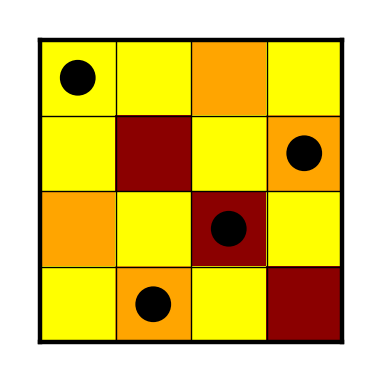

Pontuação: 8


In [98]:
chess = ChessTable(size=4,queensPosition=[0,3,2,1])
chess.drawChessboard(figureSize=1)
print("Pontuação:",chess.pontuacao)

In [76]:
crossover_rate = 1
mutation_rate = 0.8 

class AlgoritmoEvolutivo():
    def __init__(self,populacao:int = 20, n:int = 8):
        self.population = []
        self.n = n
        self.bestPontuacaoList = []
        self.meanPontuacaoList = [] 
        for i in range (populacao):
            self.population.append(ChessTable(n,queensPosition=rd.sample(range(n), n)))

            
    def CrossOver(self,parents): # Single Point Crossover
        N = parents[0].size
        offspring = np.zeros((2,N))
        offspring = [list( map(int,i) ) for i in offspring] # Convertendo todos os numeros em int
        pos = rd.randrange(N) # single point crossover -> Pega a posicao para o corte
        
        parent1 = parents[0].queens
        parent2 = parents[1].queens
        # Copia a primeira parte até o ponto de corte
        offspring[0] = parent1[:pos] + [0] * (N - pos)
        offspring[1] = parent2[:pos] + [0] * (N - pos)

        # Checa se o numero é repetido e faz o ajuste caso seja (para ser uma permutação)
        s1 = pos
        s2 = pos
        for i in range(N):
            check1 = 0
            check2 = 0
            for j in range(pos):
                if parent2[i] == offspring[0][j]:
                    check1 = 1
                if parent1[i] == offspring[1][j]:
                    check2 = 1
            if check1 == 0:
                offspring[0][s1] = parent2[i]
                s1 += 1
            if check2 == 0:
                offspring[1][s2] = parent1[i]
                s2 += 1
                
        filho1 = ChessTable(N,queensPosition=offspring[0])
        filho2 = ChessTable(N,queensPosition=offspring[1])
        return [filho1,filho2]
    

    def Mutacao(self,filhos,mutationChance):
        for individuo in filhos: # Percorre todos os individuos para checar se ocorre mutacao
            randomico = rd.random() # Pega um numero aleatorio entre 0 e 1 (float)
            if randomico < mutationChance: # Caso ocorra a mutacao
                pos = rd.sample(range(0, self.n), 2) # Selecao aleatoria de 2 posicoes
                # Inverte a posicao de 2 rainhas
                individuo.queens[pos[0]], individuo.queens[pos[1]] = individuo.queens[pos[1]], individuo.queens[pos[0]]
        return filhos
            
                
    def ParentSelector(self,PopulationSelect=5):
        '''
        Escolhe Aleatoriamente X individuos(padrao 5) na população e 
        seleciona os dois melhores destes para efetuar o crossover(cruzamento)
        '''
        
        sample = rd.sample(range(len(self.population)), PopulationSelect) # Define X individuos aleatorios
        parents = [self.population[i] for i in sample] # Seleciona os 5 candidatos a pais aleatorios
        sortedParents = sorted(parents, key=lambda population: population.pontuacao) # Ordena a selecao de pais
                                                                                     # de melhor para pior pontuacao
        parent1 = sortedParents[0] # Seleciona o 1o melhor pai
        parent2 = sortedParents[1] # Seleciona o 2o melhor pai
        return [parent1, parent2]
        
        
    def SurvivorSelector(self): # Remove os 2 piores de cada geração
        # Ordena a populacao em melhor pontuacao, sendo o indice 0 a melhor e o indice n o pior
        self.population = sorted(self.population, key=lambda population: population.pontuacao) 
        # Remove os 2 ultimos elementos
        self.population.pop()
        self.population.pop()
        
    def updateAptidoes(self):
        for individuo in self.population:
            individuo.getAptidao()
            
    def run(self,maxgen):
        ngen = 0 # numero de geracoes
        bestPontuacao = 200 # Numero alto inicial para nao travar o while

        while  (ngen < maxgen): # Condicao de termino, quando uma solucao otima for encontrada ou 
                                # quando um numero maximo de gerações tiver sido alcançado 
            parents = self.ParentSelector()
            filhos = self.CrossOver(parents) # Recombinacao dos pares dos pais


            filhosPosMutacao = self.Mutacao(filhos,mutationChance=0.8)      # Mutacao do resultado
            self.population.append(filhosPosMutacao[0]) # Adiciona o filho 0 a populacao
            self.population.append(filhosPosMutacao[1]) # Adiciona o filho 1 a populacao
            
            self.updateAptidoes() # Atualiza todas pontuacoes/aptidoes após a mutação
            self.SurvivorSelector() # Remove os 2 piores
            
            # Retorna a melhor pontuacao dessa geração
            bestPontuacao = sorted(self.population, key=lambda population: population.pontuacao)[0].pontuacao 
            self.bestPontuacaoList.append(bestPontuacao)
            self.meanPontuacaoList.append(statistics.mean([individuo.pontuacao for individuo in self.population]))
            # Ordena a populacao em melhor pontuacao, sendo o indice 0 a melhor e o indice n o pior
            self.population = sorted(self.population, key=lambda population: population.pontuacao) 
            clear_output(wait=True)
            print("Geração Atual:{}/{}         MelhorPontuação:{}".format(ngen+1,maxgen,bestPontuacao))
            if (bestPontuacao == 0):
                break
            ngen += 1
            
    def plotGraph(self): # Plota o grafico de melhor pontuacao e media por geração
        # Demonstração da convergência do algoritmo evolutivo
        plt.figure(figsize=(20,5))
        plt.scatter( list( range(0, len(algoritmo.bestPontuacaoList)) ),
                    algoritmo.bestPontuacaoList,
                    label='Melhor Pontuação')
        plt.scatter( list( range(0, len(algoritmo.bestPontuacaoList)) ),
                    algoritmo.meanPontuacaoList,
                    label="Médias Pontuação")
        plt.xlabel("Geração",fontsize=20)
        plt.ylabel("Aptidão/Pontuação",fontsize=20)
        plt.legend(prop={'size': 20})
        plt.show()

In [104]:
tamanhoTabuleiro=50
populacao = 80
algoritmo = AlgoritmoEvolutivo(populacao=populacao,n=tamanhoTabuleiro)

# 8x8   -> 20 solucoes
# 20x20 -> 50 solucoes
# 50x50 -> 100 solucoes
algoritmo.run(maxgen=5000)

Geração Atual:4192/5000         MelhorPontuação:0


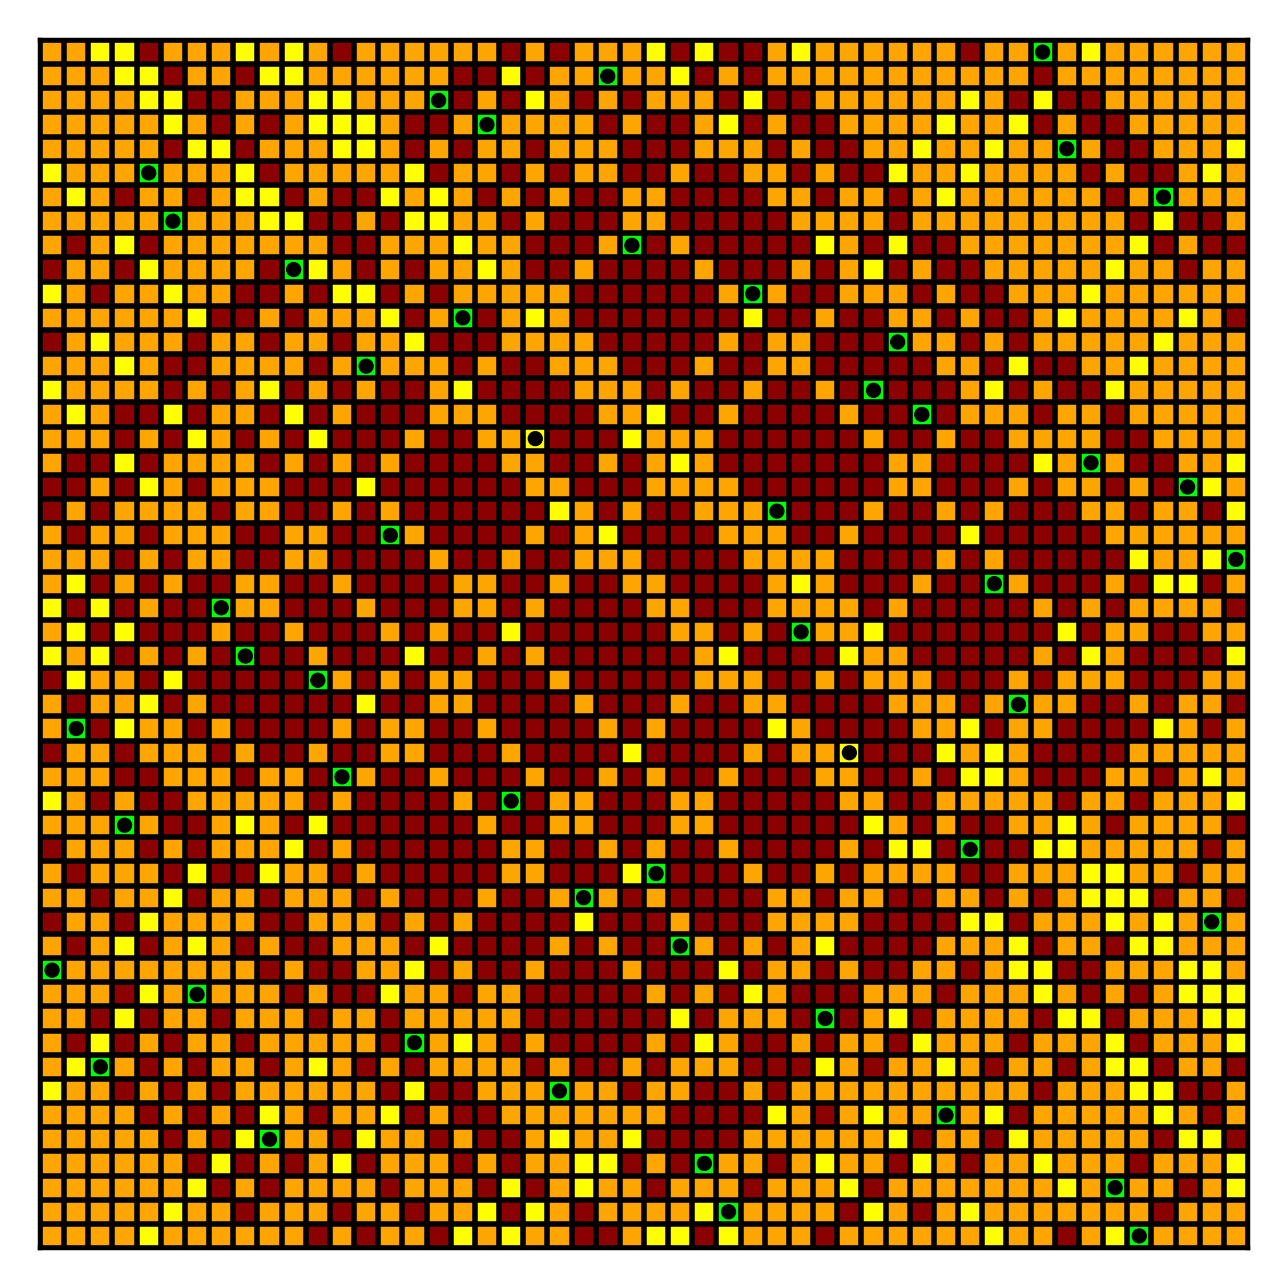

In [102]:
algoritmo.population[0].drawChessboard()

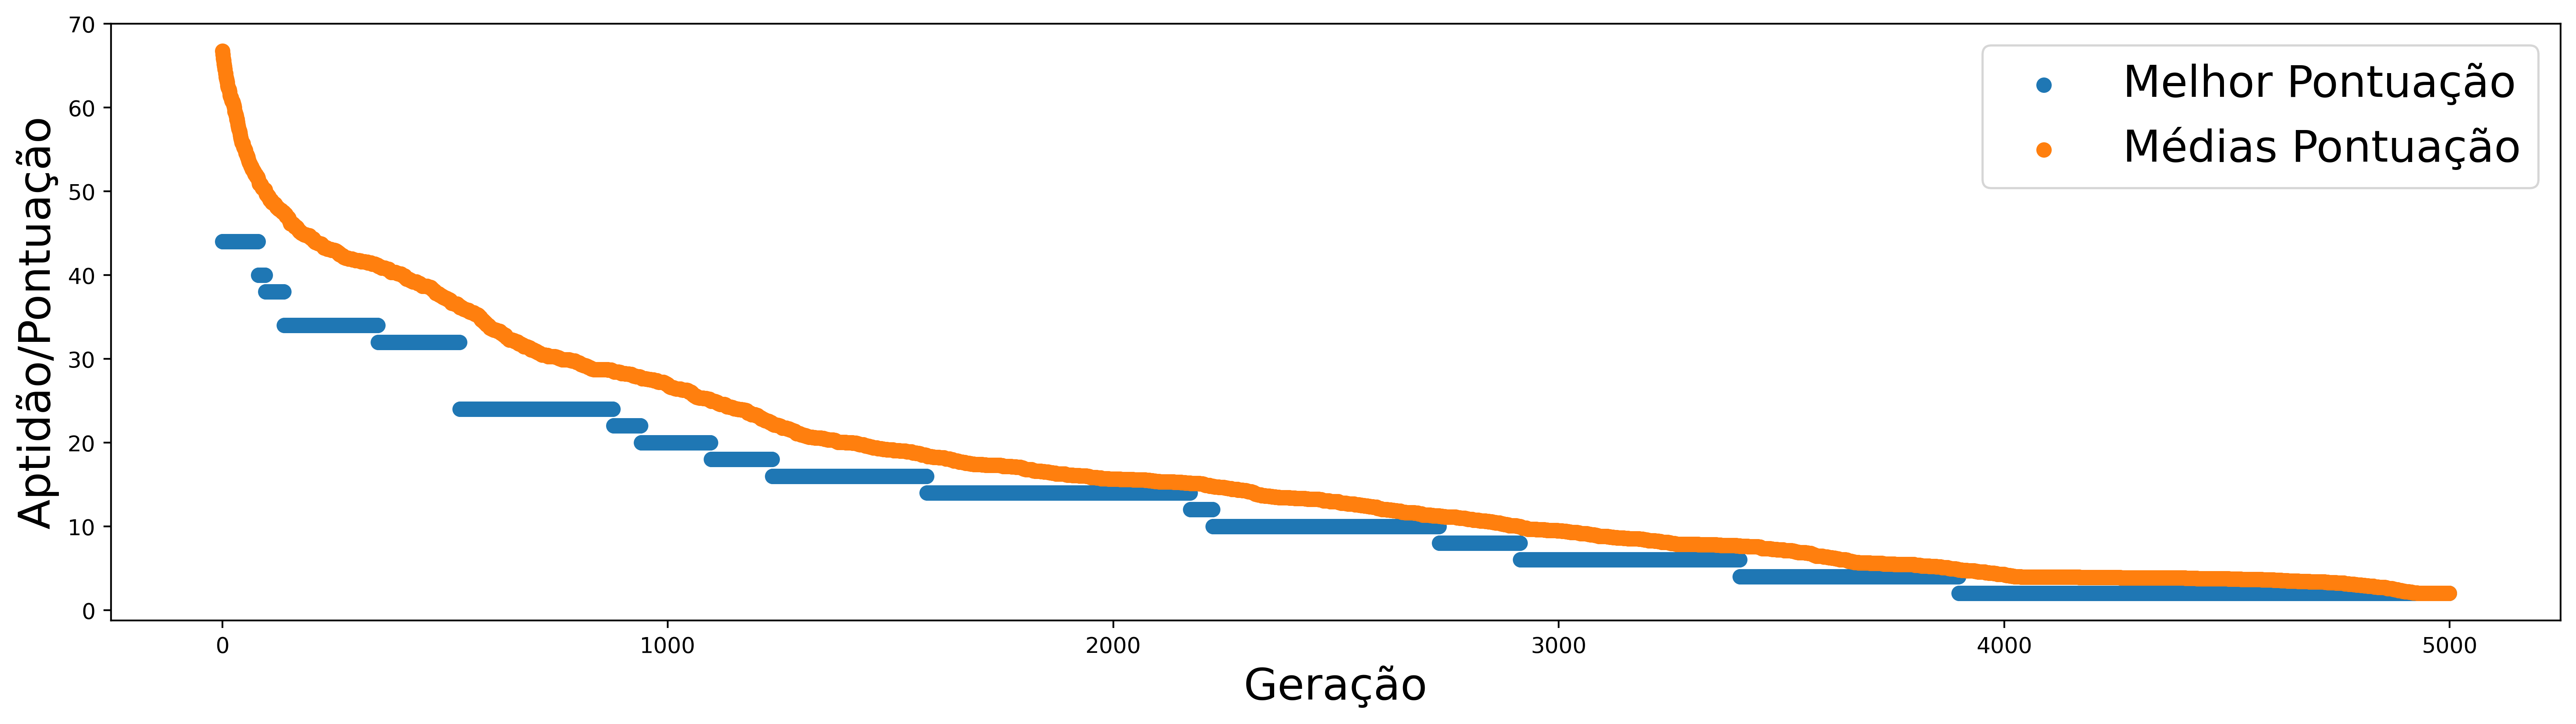

In [79]:
algoritmo.plotGraph()